In [1]:
from HAMILTONIAN import Hamiltonian
import os
import re
import json
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import calculations as calc
import PAI as pai
from HAMILTONIAN import Hamiltonian
from scipy.stats import binom
from plotting import calcOverhead
import math
from fractions import Fraction
from typing import Tuple, Optional
import time
from concurrent.futures import ProcessPoolExecutor, as_completed
from main import TE_PAI

from calculations import getCircuit, getComplexity
import quimb as qu


c:\Users\fredr\AppData\Local\Programs\Python\Python312\Lib\site-packages\cotengra\hyperoptimizers\hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
def applyGates(circuit, gates, return_index=0):
    gate_name_mapping = {
    'XX': 'rxx',
    'YY': 'ryy',
    'ZZ': 'rzz',
    'Z': 'rz'
    }
    measurements    = []
    bond_sizes      = []
    i = 1
    idx = np.linspace(0, len(gates) - 1, 10, dtype=int)
    quimb_copy = None
    for j,gate in enumerate(gates):

        if j in idx:
            val = np.real(circuit.local_expectation(qu.pauli('X'), (0)))
            measurements.append(val)
            bond_sizes.append(getComplexity(circuit)[0])

        print(f"Applying gate {i}/{len(gates)}: {gate}")
        i += 1
        # Getting gate details
        gate_name = gate[0]
        angle = gate[1]
        qubit_indices = gate[2]
        quimb_gate_name = gate_name_mapping[gate_name]

        # Apply the gate to the circuit       
        if len(qubit_indices) == 1:
            circuit.apply_gate(gate_id=quimb_gate_name, qubits=[qubit_indices[0]], params=[angle])
        elif len(qubit_indices) == 2:
            circuit.apply_gate(gate_id=quimb_gate_name, qubits=qubit_indices, params=[angle])
        else:
            raise ValueError(f"Unsupported number of qubits for gate {quimb_gate_name}: {len(qubit_indices)}")
        
        if return_index > 0 and j == return_index:
            quimb_copy = circuit.copy()

    if return_index == 0:
        return measurements, bond_sizes
    else:
        return measurements, bond_sizes, quimb_copy

def quick_plot(yData, bData, agg_label="Aggregate", last_label="Last"):
    """
    yData, bData: lists of 1D arrays (time series). All series in each list must share length.
    The first N-1 series are aggregated (mean ± std); the last series is plotted separately.
    """

    def _aggregate_all_but_last(data_list):
        last = np.asarray(data_list[-1])
        if len(data_list) > 1:
            stack = np.vstack([np.asarray(d) for d in data_list[:-1]])
            mean = stack.mean(axis=0)
            # sample std; if only one series in the aggregate, std->zeros
            std = stack.std(axis=0, ddof=1) if stack.shape[0] > 1 else np.zeros_like(mean)
        else:
            mean, std = None, None
        return mean, std, last

    # Basic shape checks
    def _check_same_length(series_list, name):
        lengths = {len(np.asarray(s)) for s in series_list}
        if len(lengths) != 1:
            raise ValueError(f"All series in {name} must have the same length. Got lengths: {sorted(lengths)}")

    if not yData or not bData:
        raise ValueError("yData and bData must be non-empty lists of time series.")

    _check_same_length(yData, "yData")
    _check_same_length(bData, "bData")

    y_mean, y_std, y_last = _aggregate_all_but_last(yData)
    b_mean, b_std, b_last = _aggregate_all_but_last(bData)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Left: Expectation value over time
    x_y = np.arange(len(y_last))
    if y_mean is not None:
        axes[0].errorbar(x_y, y_mean, yerr=y_std, fmt='-o', capsize=3, label=agg_label)
    axes[0].plot(x_y, y_last, label=last_label)
    axes[0].set_title("Expectation value over time")
    axes[0].legend()

    # Right: Maximal bond dimension over time
    x_b = np.arange(len(b_last))
    if b_mean is not None:
        axes[1].errorbar(x_b, b_mean, yerr=b_std, fmt='-o', capsize=3, label=agg_label)
    axes[1].plot(x_b, b_last, label=last_label)
    axes[1].set_title("Maximal bond dimension over time")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [6]:
# Setting up TE-PAI
q = 20
T = 1.0
N = 100
n_snap = 1
num_circuits = 1
rng = np.random.default_rng(0)
freqs = rng.uniform(-1, 1, size=q)
hamil = Hamiltonian.spin_chain_hamil(q, freqs)

quimb = getCircuit(q, flip=True, max_bond=2)

times = np.linspace(0, T, N)
terms = [hamil.get_term(t) for t in times]
initial_gates = []
n = int(N / n_snap)
for i in range(N):
    if i % n == 0:
        initial_gates.append([])
    initial_gates[-1] += [
        (pauli, 2 * coef * T / N, ind)
        for (pauli, ind, coef) in terms[i]
    ]

measurements_i, bonds_i, tepai_circuit = applyGates(quimb, initial_gates[0], return_index=int(len(initial_gates[0])*0.75))
print("Measurements so far:", measurements_i)
print("Bond sizes so far:", bonds_i)
trott_cost = len(quimb.gates)*bonds_i[-1]**3
print("Final cost:", trott_cost)


The number of qubit:20
Number of terms in the Hamiltonian:80
Applying gate 1/8000: ('XX', 0.002, [0, 1])
Applying gate 2/8000: ('YY', 0.002, [0, 1])
Applying gate 3/8000: ('ZZ', 0.002, [0, 1])
Applying gate 4/8000: ('XX', 0.002, [1, 2])
Applying gate 5/8000: ('YY', 0.002, [1, 2])
Applying gate 6/8000: ('ZZ', 0.002, [1, 2])
Applying gate 7/8000: ('XX', 0.002, [2, 3])
Applying gate 8/8000: ('YY', 0.002, [2, 3])
Applying gate 9/8000: ('ZZ', 0.002, [2, 3])
Applying gate 10/8000: ('XX', 0.002, [3, 4])
Applying gate 11/8000: ('YY', 0.002, [3, 4])
Applying gate 12/8000: ('ZZ', 0.002, [3, 4])
Applying gate 13/8000: ('XX', 0.002, [4, 5])
Applying gate 14/8000: ('YY', 0.002, [4, 5])
Applying gate 15/8000: ('ZZ', 0.002, [4, 5])
Applying gate 16/8000: ('XX', 0.002, [5, 6])
Applying gate 17/8000: ('YY', 0.002, [5, 6])
Applying gate 18/8000: ('ZZ', 0.002, [5, 6])
Applying gate 19/8000: ('XX', 0.002, [6, 7])
Applying gate 20/8000: ('YY', 0.002, [6, 7])
Applying gate 21/8000: ('ZZ', 0.002, [6, 7])
App

In [8]:
N = 1000
Δ = np.pi / (2**8)
T = 5.0
q = 20
n_snap = 1
num_circuits = 1

rng = np.random.default_rng(0)
freqs = rng.uniform(-1, 1, size=q)
hamil = Hamiltonian.spin_chain_hamil(q, freqs)
tepai = TE_PAI(hamil,q,Δ,T,N,n_snap)
tepai_count = tepai.expected_num_gates
print("TEPAI number of gates:", tepai_count)

circuit_details = tepai.run_te_pai(
    num_circuits=num_circuits,
    sign_file_path=None,
    gates_file_path=None,
    overhead=tepai.overhead
)
tepai_signs = [detail[0] for detail in circuit_details]
tepai_gates = [detail[1] for detail in circuit_details]

print("Signs:", tepai_signs)
print("Lengths of tepai circuits:", [len(gate_list[0]) for gate_list in tepai_gates])

if True:
    this_tepai_circuit = getCircuit(q, flip=True)#tepai_circuit.copy()
    for gates_arr in tepai_gates:
        # Executing the TE-PAI circuit
        tepai_m, tepai_b = applyGates(this_tepai_circuit, gates_arr[0])
        print("tepai bond dimension:", tepai_b)
        print("tepai measurements:", tepai_m)

    tepai_cost = len(this_tepai_circuit.gates)*tepai_b[-1]**3
    print("Final TEPAI cost:", tepai_cost)
    print(f"TEPAI / Trotter cost ratio: {tepai_cost / trott_cost}")


The number of qubit:20
Number of terms in the Hamiltonian:80
TEPAI number of gates: 14218.319220965606
Signs: [1]
Lengths of tepai circuits: [14336]
Applying gate 1/14336: ('ZZ', np.float64(0.01227184630308513), [4, 5])
Applying gate 2/14336: ('XX', np.float64(0.01227184630308513), [5, 6])
Applying gate 3/14336: ('XX', np.float64(0.01227184630308513), [10, 11])
Applying gate 4/14336: ('XX', np.float64(0.01227184630308513), [13, 14])
Applying gate 5/14336: ('ZZ', np.float64(0.01227184630308513), [17, 18])
Applying gate 6/14336: ('Z', np.float64(0.01227184630308513), [0])
Applying gate 7/14336: ('Z', np.float64(-0.01227184630308513), [2])
Applying gate 8/14336: ('Z', np.float64(0.01227184630308513), [5])
Applying gate 9/14336: ('Z', np.float64(0.01227184630308513), [7])
Applying gate 10/14336: ('Z', np.float64(0.01227184630308513), [9])
Applying gate 11/14336: ('Z', np.float64(0.01227184630308513), [10])
Applying gate 12/14336: ('Z', np.float64(-0.01227184630308513), [11])
Applying gate 

NameError: name 'trott_cost' is not defined

In [ ]:
this_tepai_circuit = tepai_circuit.copy()
tepai_ms = []
tepai_bs = []
for gates_arr in tepai_gates:
    # Executing the TE-PAI circuit
    tepai_m, tepai_b = applyGates(this_tepai_circuit, gates_arr[0])
    print("tepai bond dimension:", tepai_b)
    print("tepai measurements:", tepai_m)
    tepai_ms.append(tepai_m)
    tepai_bs.append(tepai_b)

comparison = tepai_ms[0]


Applying gate 1/5648: ('XX', np.float64(0.006135923151542565), [2, 3])
Applying gate 2/5648: ('Z', np.float64(-0.006135923151542565), [3])
Applying gate 3/5648: ('XX', np.float64(0.006135923151542565), [4, 5])
Applying gate 4/5648: ('YY', np.float64(0.006135923151542565), [10, 11])
Applying gate 5/5648: ('ZZ', np.float64(0.006135923151542565), [13, 14])
Applying gate 6/5648: ('YY', np.float64(0.006135923151542565), [15, 16])
Applying gate 7/5648: ('Z', np.float64(0.006135923151542565), [10])
Applying gate 8/5648: ('Z', np.float64(0.006135923151542565), [12])
Applying gate 9/5648: ('Z', np.float64(-0.006135923151542565), [15])
Applying gate 10/5648: ('Z', np.float64(-0.006135923151542565), [18])
Applying gate 11/5648: ('Z', np.float64(0.006135923151542565), [9])
Applying gate 12/5648: ('Z', np.float64(0.006135923151542565), [14])
Applying gate 13/5648: ('ZZ', np.float64(0.006135923151542565), [6, 7])
Applying gate 14/5648: ('ZZ', np.float64(0.006135923151542565), [18, 19])
Applying gate

In [290]:
print(len(tepai_circuit.gates))

29340


In [282]:
# Setting up Trotterization

# Number of Trotter steps to match TEPAI gate count
N = 200
times = np.linspace(0, T, N)
terms = [hamil.get_term(t) for t in times]
gates = []
n = int(N / n_snap)

for i in range(N):
    if i % n == 0:
        gates.append([])
    gates[-1] += [
        (pauli, 2 * coef * T / N, ind)
        for (pauli, ind, coef) in terms[i]
    ]
print("Trotter gates:", sum(len(g) for g in gates))


Trotter gates: 16000


In [283]:
# Executing the Trotter circuit
trott_circuit = quimb.copy()
trott_m, trott_b = applyGates(trott_circuit, gates[0])
print("Bond dimension:", trott_b)


Applying gate 1/16000: ('XX', 0.001, [0, 1])
Applying gate 2/16000: ('YY', 0.001, [0, 1])
Applying gate 3/16000: ('ZZ', 0.001, [0, 1])
Applying gate 4/16000: ('XX', 0.001, [1, 2])
Applying gate 5/16000: ('YY', 0.001, [1, 2])
Applying gate 6/16000: ('ZZ', 0.001, [1, 2])
Applying gate 7/16000: ('XX', 0.001, [2, 3])
Applying gate 8/16000: ('YY', 0.001, [2, 3])
Applying gate 9/16000: ('ZZ', 0.001, [2, 3])
Applying gate 10/16000: ('XX', 0.001, [3, 4])
Applying gate 11/16000: ('YY', 0.001, [3, 4])
Applying gate 12/16000: ('ZZ', 0.001, [3, 4])
Applying gate 13/16000: ('XX', 0.001, [4, 5])
Applying gate 14/16000: ('YY', 0.001, [4, 5])
Applying gate 15/16000: ('ZZ', 0.001, [4, 5])
Applying gate 16/16000: ('XX', 0.001, [5, 6])
Applying gate 17/16000: ('YY', 0.001, [5, 6])
Applying gate 18/16000: ('ZZ', 0.001, [5, 6])
Applying gate 19/16000: ('XX', 0.001, [6, 7])
Applying gate 20/16000: ('YY', 0.001, [6, 7])
Applying gate 21/16000: ('ZZ', 0.001, [6, 7])
Applying gate 22/16000: ('XX', 0.001, [7, 8

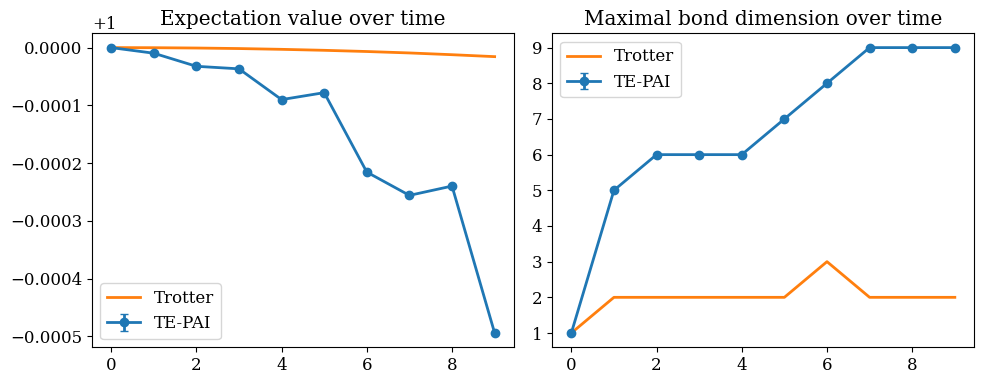

In [284]:
quick_plot(yData=tepai_ms+[trott_m], bData=tepai_bs+[trott_b], agg_label="TE-PAI", last_label="Trotter")